This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [2]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip

**Inspecting the data of the Jena weather dataset**

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016/jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

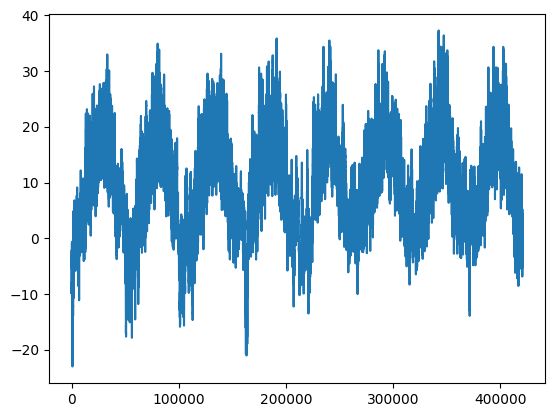

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.savefig("../pngs/10ch/temperature.png")

**Plotting the first 10 days of the temperature timeseries**

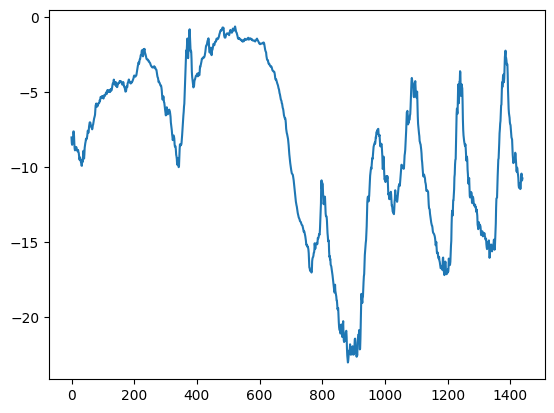

In [6]:
plt.plot(range(1440), temperature[:1440])
plt.savefig("../pngs/10ch/temperature_10days.png")

**Computing the number of samples we'll use for each data split**

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 13s 13ms/step - loss: 12.7085 - mae: 2.7628 - val_loss: 11.8056 - val_mae: 2.7105
Epoch 2/10
819/819 [==============================] - 12s 15ms/step - loss: 9.2155 - mae: 2.3947 - val_loss: 11.0363 - val_mae: 2.6266
Epoch 3/10
819/819 [==============================] - 12s 14ms/step - loss: 8.4548 - mae: 2.2931 - val_loss: 10.2413 - val_mae: 2.5175
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 7.9990 - mae: 2.2308 - val_loss: 10.3711 - val_mae: 2.5461
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 7.7076 - mae: 2.1901 - val_loss: 10.3969 - val_mae: 2.5412
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 7.4333 - mae: 2.1514 - val_loss: 11.4555 - val_mae: 2.6794
Epoch 7/10
819/819 [==============================] - 12s 15ms/step - loss: 7.2369 - mae: 2.1220 - val_loss: 11.7412 - val_mae: 2.7241
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

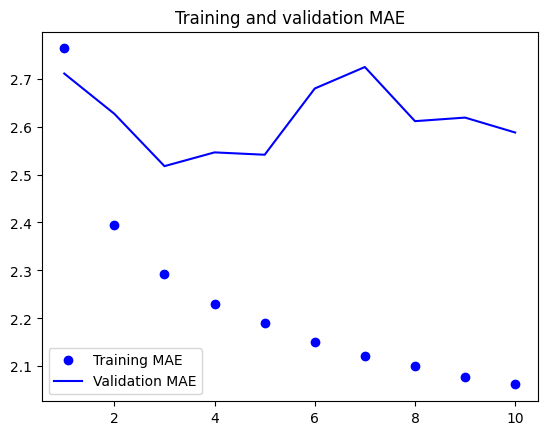

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.savefig("../pngs/10ch/naive_mae.png")
plt.show()

### Let's try a 1D convolutional model

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 24s 29ms/step - loss: 23.9675 - mae: 3.7838 - val_loss: 16.3784 - val_mae: 3.2082
Epoch 2/10
819/819 [==============================] - 25s 30ms/step - loss: 15.6108 - mae: 3.1350 - val_loss: 19.8392 - val_mae: 3.5631
Epoch 3/10
819/819 [==============================] - 25s 31ms/step - loss: 14.3538 - mae: 3.0040 - val_loss: 15.5175 - val_mae: 3.1193
Epoch 4/10
819/819 [==============================] - 25s 31ms/step - loss: 13.5033 - mae: 2.9104 - val_loss: 16.7227 - val_mae: 3.2386
Epoch 5/10
819/819 [==============================] - 25s 31ms/step - loss: 12.8355 - mae: 2.8324 - val_loss: 14.4536 - val_mae: 2.9977
Epoch 6/10
819/819 [==============================] - 26s 31ms/step - loss: 12.2860 - mae: 2.7691 - val_loss: 17.3747 - val_mae: 3.3082
Epoch 7/10
819/819 [==============================] - 26s 32ms/step - loss: 11.8446 - mae: 2.7185 - val_loss: 16.8046 - val_mae: 3.2430
Epoch 8/10
819/819 [============================

### A first recurrent baseline

In [16]:
# Pseudo code
# state_t = 0
# for input_t in input_sequence:
# output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
# state_t = output_t

**A simple LSTM-based model**

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 59s 70ms/step - loss: 43.0707 - mae: 4.7510 - val_loss: 12.3939 - val_mae: 2.6830
Epoch 2/10
819/819 [==============================] - 87s 106ms/step - loss: 11.0737 - mae: 2.5851 - val_loss: 9.8812 - val_mae: 2.4463
Epoch 3/10
819/819 [==============================] - 83s 101ms/step - loss: 9.9777 - mae: 2.4627 - val_loss: 9.8995 - val_mae: 2.4390
Epoch 4/10
819/819 [==============================] - 56s 69ms/step - loss: 9.5947 - mae: 2.4111 - val_loss: 9.8623 - val_mae: 2.4289
Epoch 5/10
819/819 [==============================] - 52s 64ms/step - loss: 9.3778 - mae: 2.3802 - val_loss: 9.8072 - val_mae: 2.4214
Epoch 6/10
819/819 [==============================] - 62s 76ms/step - loss: 9.1954 - mae: 2.3576 - val_loss: 9.9428 - val_mae: 2.4378
Epoch 7/10
819/819 [==============================] - 70s 85ms/step - loss: 8.8919 - mae: 2.3203 - val_loss: 10.2539 - val_mae: 2.4745
Epoch 8/10
819/819 [==============================] - 61

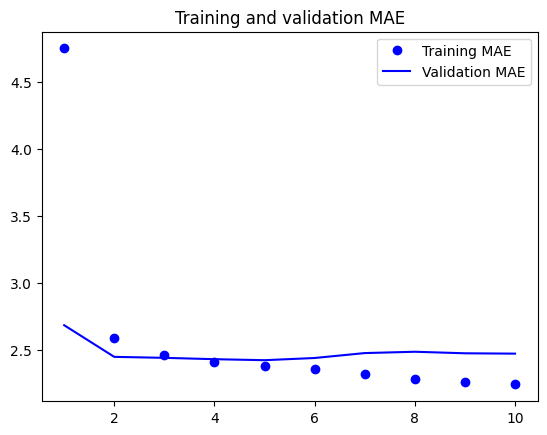

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.savefig("../pngs/10ch/rnn_mae.png")
plt.show()

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [19]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [20]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [21]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [22]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [23]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/30
819/819 [==============================] - 116s 138ms/step - loss: 28.1664 - mae: 3.9137 - val_loss: 10.1584 - val_mae: 2.4659
Epoch 2/30
819/819 [==============================] - 126s 153ms/step - loss: 14.8439 - mae: 2.9936 - val_loss: 9.7148 - val_mae: 2.4196
Epoch 3/30
819/819 [==============================] - 131s 159ms/step - loss: 14.0385 - mae: 2.9104 - val_loss: 9.9474 - val_mae: 2.4569
Epoch 4/30
819/819 [==============================] - 145s 177ms/step - loss: 13.4296 - mae: 2.8436 - val_loss: 9.2446 - val_mae: 2.3599
Epoch 5/30
819/819 [==============================] - 152s 186ms/step - loss: 12.8979 - mae: 2.7860 - val_loss: 9.1549 - val_mae: 2.3553
Epoch 6/30
819/819 [==============================] - 144s 175ms/step - loss: 12.5126 - mae: 2.7456 - val_loss: 9.4682 - val_mae: 2.3851
Epoch 7/30
819/819 [==============================] - 134s 164ms/step - loss: 12.1400 - mae: 2.7061 - val_loss: 9.6328 - val_mae: 2.4081
Epoch 8/30
819/819 [====================

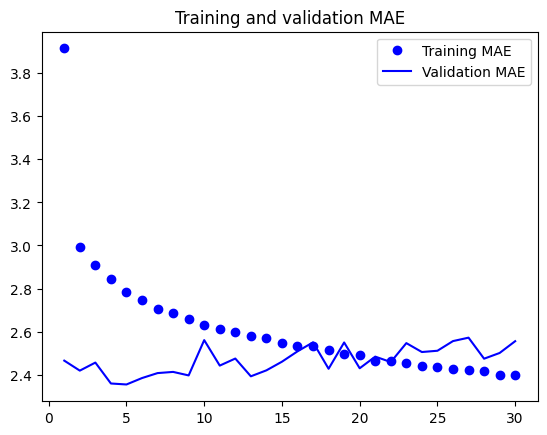

In [25]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.savefig("../pngs/10ch/rnn_dropout_mae.png")
plt.show()

In [26]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/30
819/819 [==============================] - 232s 280ms/step - loss: 23.9926 - mae: 3.6379 - val_loss: 9.4004 - val_mae: 2.3752
Epoch 2/30
819/819 [==============================] - 325s 397ms/step - loss: 14.1842 - mae: 2.9207 - val_loss: 9.0058 - val_mae: 2.3253
Epoch 3/30
819/819 [==============================] - 325s 396ms/step - loss: 13.3326 - mae: 2.8273 - val_loss: 8.7408 - val_mae: 2.2928
Epoch 4/30
819/819 [==============================] - 290s 354ms/step - loss: 12.6980 - mae: 2.7631 - val_loss: 8.8682 - val_mae: 2.3064
Epoch 5/30
819/819 [==============================] - 311s 379ms/step - loss: 12.1969 - mae: 2.7064 - val_loss: 8.9419 - val_mae: 2.3172
Epoch 6/30
819/819 [==============================] - 300s 366ms/step - loss: 11.7982 - mae: 2.6638 - val_loss: 9.4061 - val_mae: 2.3738
Epoch 7/30
819/819 [==============================] - 288s 351ms/step - loss: 11.3532 - mae: 2.6134 - val_loss: 9.1232 - val_mae: 2.3310
Epoch 8/30
819/819 [=====================

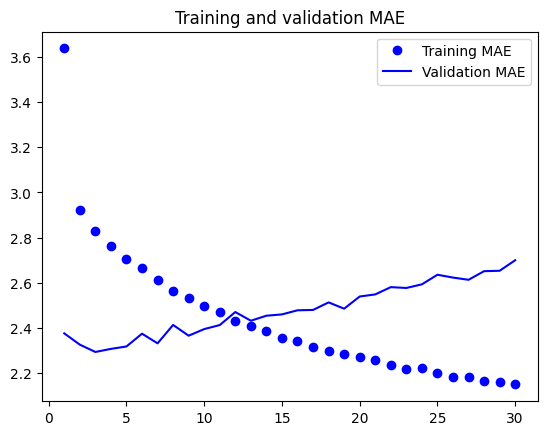

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.savefig("../pngs/10ch/gru_mae.png")
plt.show()

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 65s 77ms/step - loss: 28.0718 - mae: 3.7947 - val_loss: 10.4181 - val_mae: 2.5081
Epoch 2/10
819/819 [==============================] - 66s 81ms/step - loss: 9.7742 - mae: 2.4429 - val_loss: 10.0023 - val_mae: 2.4587
Epoch 3/10
819/819 [==============================] - 71s 86ms/step - loss: 8.8528 - mae: 2.3178 - val_loss: 9.6074 - val_mae: 2.3994
Epoch 4/10
819/819 [==============================] - 87s 106ms/step - loss: 8.3573 - mae: 2.2504 - val_loss: 9.9606 - val_mae: 2.4445
Epoch 5/10
819/819 [==============================] - 79s 96ms/step - loss: 7.9825 - mae: 2.1984 - val_loss: 9.4280 - val_mae: 2.3669
Epoch 6/10
819/819 [==============================] - 82s 100ms/step - loss: 7.6739 - mae: 2.1532 - val_loss: 9.5736 - val_mae: 2.3964
Epoch 7/10
819/819 [==============================] - 81s 98ms/step - loss: 7.4113 - mae: 2.1167 - val_loss: 9.6112 - val_mae: 2.3906
Epoch 8/10
819/819 [==============================] - 84s

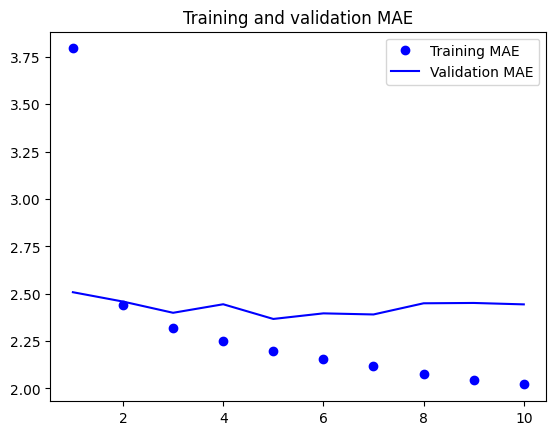

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.savefig("../pngs/10ch/rnn_bidirectional_mae.png")
plt.show()

### Going even further

## Summary